In [1]:
from keras.models import load_model
from numpy import expand_dims
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
!pip install mtcnn
from mtcnn.mtcnn import MTCNN
from os.path import isdir
import os
import tensorflow as tf

     |████████████████████████████████| 2.3MB 7.6MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/mcproject

/content/drive/MyDrive/mcproject


In [4]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [5]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
batch_size = 128
epochs = 50
inChannel = 1
x, y =84,84
input_img = Input(shape = (x, y, inChannel))

In [7]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.load_weights('KNN_54.h5')

In [9]:
import pickle
loaded_model = pickle.load(open('KNN_54_No_Mask.pkl', 'rb'))

In [11]:

from numpy import load
data = load('autoencoder1K.npz')
X, Y= data['arr_0'], data['arr_1']
def get_embedding(model,face_pixels):
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    l=list()
    l.append(face_pixels)
    l=np.array(l)
    # make prediction to get embedding
    yhat = autoencoder.predict(l)
    return yhat[0]
NX=[]
for face_pixels in X:
    
    embedding = get_embedding(autoencoder, face_pixels)
    NX.append(embedding)
newTestX = asarray(NX)

In [28]:
print(newTestX.shape)
r=newTestX.reshape(84,84,1000)
r=newTestX.reshape(-1,1000)
r=newTestX.reshape(1000,7056)
trainX=r[800:]
testX1=r[:800]
testX=r[:800]
testy=Y[:800]
trainy=Y[800:]

(1000, 84, 84, 1)


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(Y)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
out_encoder.classes_
y_hat=loaded_model.predict(testX)
y_hat=out_encoder.inverse_transform(y_hat)
testy=out_encoder.inverse_transform(testy)

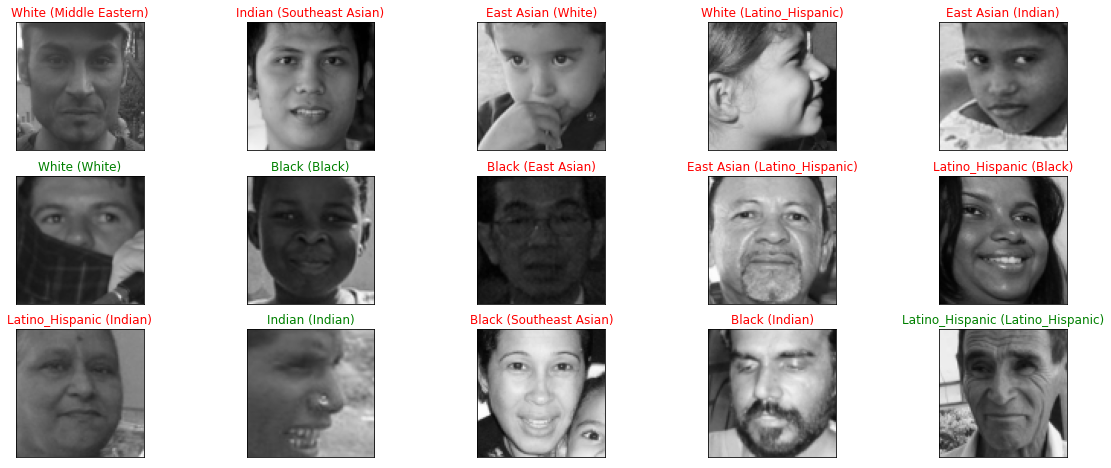

In [30]:
from google.colab.patches import cv2_imshow
labels =['Black', 'East Asian', 'Indian', 'Latino_Hispanic',
       'Middle Eastern', 'Southeast Asian', 'White']

import cv2
import matplotlib.pyplot as plt
x_val=X[:800]
y_val=testy



figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_val.shape[0], size=15,replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(cv2.cvtColor(x_val[index], cv2.COLOR_BGR2RGB))
    predict_index = y_hat[index]
    true_index = y_val[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(predict_index, 
                                  true_index),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()